Сделать преобразование Фурье для каждой W-формы, построить профиль сигнала 
Окно "Кайзера" для перемножения сигнала, сглаживание фурье образа
fдиск = 120 kHz

Loading data: 12119it [00:06, 1827.91it/s]


<class 'list'>
(513, 1024)


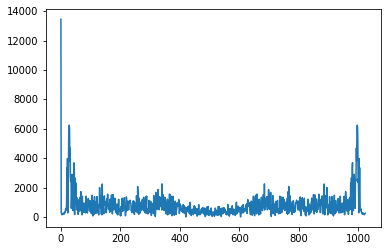

In [25]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, rfftfreq, rfft

%matplotlib inline


def snldataload(full_name, mode=1):
    D = []  # List of Depths recorded in all stations (list of numpy.arrays)
    T = []  # List of Time (if exist) recorded in all stations (list of numpy.arrays)
    DATA = []  # Data in the stations

    with open(full_name, "r") as f:
        next(f)  # skip header
        next(f)  # skip header
        d = []
        t = []
        data = []
        for line in tqdm(f, desc="Loading data"):
            if line.isspace():
                D.append(np.array(d))
                T.append(np.array(t))
                DATA.append(np.array(data))
                d.clear()
                t.clear()
                data.clear()
                continue
            words = line.strip().split(' ')
            deph_time = words[0].split('|')
            d.append(float(deph_time[0]))
            if (len(deph_time) > 1):
                t.append(float(deph_time[1]))

            data_list = list(map(int, words[1:]))
            data.append(np.array(data_list))

        if d and data:
            D.append(np.array(d))
            DATA.append(np.array(data))
        if t:
            T.append(np.array(t))

    if mode != 1:
        DATA = [d.reshape(-1, 1024 * mode) for d in DATA]
        D = [d[0::mode] for d in D]

        if T:
            T = [t[0::mode] for t in T]

    return [D, T, DATA]

def save2las(file_name, depth, depth_units, data, data_names, data_units, fmt="%.6e"):  # noqa C901

    # Check input data
    if len(depth) == 0:  # Check depth log
        raise Exception("Depth log is empty!")

    if len(data) == 0:  # Check data size
        raise Exception("Data logs weren't found!")

    if len(data) != len(data_units) or len(data) != len(data_names):
        raise Exception("Datasets, dataset names and dataset units size mismatch!")

    depth_size = np.shape(depth)
    if len(depth_size) > 1:  # Check dimension of depth data
        raise Exception("Depth log must by a 1D-vector!")

    for ds in data:  # Check sizes of the depth log and exported data
        if not isinstance(ds, np.ndarray):
            raise Exception("All exported data must be numpy arrays!")
        ds_size = np.shape(ds)
        if not ds_size[0] == depth_size[0]:
            raise Exception("Depth log and the exported data size mismatch!")

    try:
        f = open(file_name, "w")  # Try to open output las-file
    except IOError:
        print(f"Error! Can't open file {file_name} to write!")
        raise

    # Input data preparation
    dept = np.array(depth, np.float64)
    dept[np.isnan(dept)] = -999.25  # Replace nan data with -999.25
    dept.shape = (len(dept), 1)  # Depth-log is a column-vector
    for i in range(0, len(data)):
        data[i][np.isnan(ds)] = -999.25  # Replace nan data with -999.25
        ds_size = np.shape(data[i])
        if len(ds_size) == 1:
            data[i].shape = (len(dept), 1)

    # Form header of las-file
    header = []
    header.append("~VERSION INFORMATION")
    header.append("VERS           .                                 2.0 : CWLS LOG ASCII STANDART - VERSION 2.0")
    header.append("WRAP           .                                  NO : ONE LINE PER DEPTH STEP")
    header.append("#END VERSION INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~WELL INFORMATION SECTION")
    header.append("#MNEM          .UNIT                      VALUE/NAME : DESCRIPTION")
    header.append("#----          .----                      ---------- : -----------")
    header.append("NULL           .                           -999.2500 : NULL VALUE")
    header.append("#END WELL INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~CURVE INFORMATION")
    header.append("DEPTH           ." + depth_units + (36 - len(depth_units)) * " " + ": MEASURED DEPTH")
    for i in range(0, len(data)):
        ds_name = data_names[i]
        ds_units = data_units[i]
        ds_data = data[i]
        ds_size = np.shape(ds_data)
        if ds_size[1] > 1:  # if dataset in the 'data' list is 2D
            for j in range(1, ds_size[1] + 1):
                log_name = ds_name + str(j)
                header.append(
                    log_name + (14 - len(log_name)) * " " + " ." + ds_units + (36 - len(ds_units)) * " " + " :"
                )
        else:
            log_name = ds_name
            header.append(log_name + (14 - len(log_name)) * " " + " ." + ds_units + (36 - len(ds_units)) * " " + " :")
    header.append("#END CURVE INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~PARAMETER INFORMATION")
    header.append("#END PARAMETER INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~OTHER INFORMATION")
    header.append("#END OTHER INFORMATION")
    header.append("#")
    header.append("#")

    all_names = ["DEPTH"]
    logs_totally = 1
    for i in range(0, len(data)):
        log_names = [data_names[i]]
        ds_size = np.shape(data[i])
        if (
                ds_size[1] > 1
        ):  # if dataset in the 'data' list is 2D then put number to log names (i.e. 'SNL1', 'SNL2' and so on)
            logs_totally += ds_size[1]
            log_names = log_names * ds_size[1]
            log_names = list(map(lambda a, b: a + b, log_names, list(map(str, range(1, ds_size[1] + 1)))))
        else:  # else if the dataset is 1D
            logs_totally += 1
        all_names = all_names + log_names
    header.append("\t".join(all_names))
    header.append("~ASCII LOG DATA")

    # Save string data to the las-file
    all_data = dept
    for ds in data:
        all_data = np.append(all_data, ds, axis=1)  # full-data matrix which includes all data

    file_header = "\n".join(header)
    np.savetxt(f, all_data, header=file_header, delimiter="\t", newline="\n", comments="", fmt=fmt)
    f.close()

    print("file " + file_name + " saved successfully.")

[D1, T1, DATA1] = snldataload('stations_1787(2-areal)_HFP.txt')

print(type(DATA1))
print(DATA1[0].shape)

plt.plot(abs(fft(DATA1[0][0])))
plt.show()
# save2las(f"{out_dir_name}sg_panel_nn_p_fl.las", d, "m", [sg_panel], ["SMALL GRAINS PANEL"], ["frac"], fmt="%.6e")

<IPython.core.display.Javascript object>


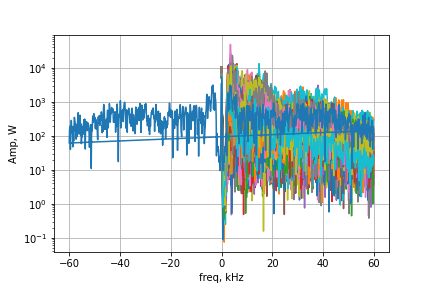

"for i in range(5):\n    process_data = mode_point(DATA1[i])\n    x, y = fft_data(i)\n    y = np.array(y)*2\n    ax.plot(x[:512:], y[:512:])\n    \nplt.yscale('log')\nplt.grid()\nplt.xlabel('freq, kHz')\nplt.ylabel('Amp, W')\nplt.show()"

In [366]:
import statistics as st

%matplotlib notebook


def mean_point(data):
    data_mean = []
    for elem in data:
        data_mean.append(elem.mean(axis=0))
    return data_mean
#end_def
#
# *****************************************************************************
def median_point(data):
    data_median = []
    for elem in data:
        data_median.append(np.median(elem, axis=0))
    return data_median
#end_def
#
# *****************************************************************************
def mode_point(data):
    data_mode = []
    data = data.transpose()
    for k in data:
        data_mode.append(st.mode(k))
    return data_mode
#end_def
#
# *****************************************************************************
def fft_data(data):
    B = np.kaiser(1024, 10)
    data = np.multiply(data, B)
    ampl = abs(fft(data))
    freq = fftfreq(1024, 1/120)

    return [freq, ampl]
#end_def
#
# *****************************************************************************
fig, ax = plt.subplots()

process_data = mean_point(DATA1)

X, Y = [], []

for i in process_data[:320]:
    x, y = fft_data(i)
    X.append(x[:512])
    Y.append(y[:512])
    y = np.array(y)*2
    x = np.array(x)
    ax.plot(x[:512:], y[:512:])

plt.yscale('log')
plt.grid()
plt.xlabel('freq, kHz')
plt.ylabel('Amp, W')
plt.show()

'''
Скрипт ниже для случая с модой для усреднения данных
'''

'''for i in range(5):
    process_data = mode_point(DATA1[i])
    x, y = fft_data(i)
    y = np.array(y)*2
    ax.plot(x[:512:], y[:512:])
    
plt.yscale('log')
plt.grid()
plt.xlabel('freq, kHz')
plt.ylabel('Amp, W')
plt.show()'''


In [104]:
#A = [i for j in X for i in j]
#B = [i for j in Y for i in j]
C = [i[0] for j in range(512) for i in D1]+[1]

<IPython.core.display.Javascript object>


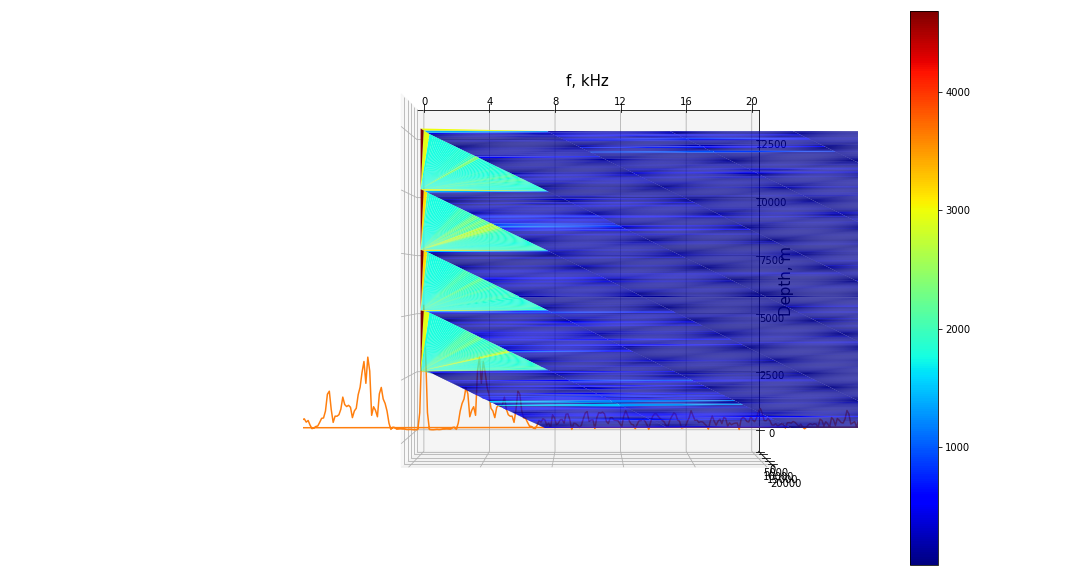

In [358]:
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(A, C, B, cmap=cm.jet, linewidth=1)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.view_init(90,-90)
ax.set_xlabel('f, kHz', fontsize = 15)
ax.set_ylabel('Depth, m', fontsize = 15)
ax.set_xlim(0, 20)
fig.tight_layout()

plt.show()

320 остановок

In [68]:
%matplotlib inline
DATA_FFT = []

freq = rfftfreq(1024, 1/120)

for i in range(len(DATA1)):
    DATA_FFT.append(np.array([np.abs(rfft(DATA1[i][j])) for j in range(len(DATA1[i]))]))
    
plt.plot(freq, DATA_FFT[1].mean(axis=0)) ### Для каждой остановки нужно будет усреднить 

C=[]

for i in D1:
    C.append(np.array([i[0] for j in range(513)]))


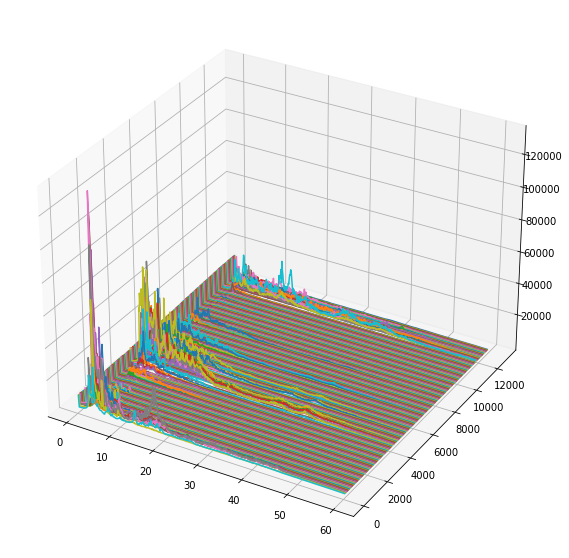

In [139]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in range(len(DATA_FFT)):
    ax.plot(freq, C[i], DATA_FFT[i].mean(axis=0))

plt.show()

In [150]:
DATA_FFT[1].shape
Xs, Ys = [], []
for i in range(len(DATA_FFT)):
    Xs = np.zeros(DATA_FFT[i].mean(axis=0).shape, DATA_FFT[i].mean(axis=0).shape)
    Ys = np.zeros(DATA_FFT[i].mean(axis=0).shape, DATA_FFT[i].mean(axis=0).shape)
    
    

TypeError: Tuple must have size 2, but has size 1

In [174]:

Xs = [np.array(freq) for i in range(320)]
Ys = np.array(C)
Zs = [DATA_FFT[i].mean(axis=0) for i in range(320)]



In [122]:
C=[]

for i in D1:
    C.append(np.array([i[0] for j in range(513)]))

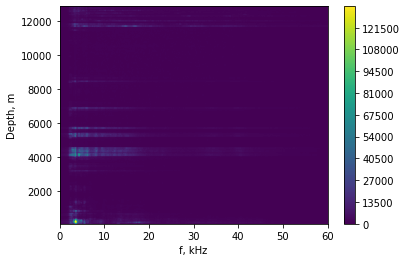

In [178]:
plt.contourf(Xs, Ys, Zs, 1000)
plt.xlabel('f, kHz')
plt.ylabel('Depth, m')
plt.colorbar()
plt.show()

In [ ]:
file_name, depth, depth_units, data, data_names, data_units, fmt="%.6e")

Exception: Datasets, dataset names and dataset units size mismatch!

Loading data: 12119it [00:03, 3181.01it/s]


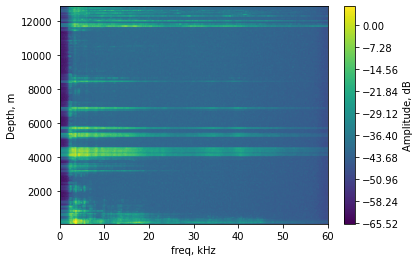

In [189]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, rfftfreq, rfft




def snldataload(full_name, mode=1):
    D = []  # List of Depths recorded in all stations (list of numpy.arrays)
    T = []  # List of Time (if exist) recorded in all stations (list of numpy.arrays)
    DATA = []  # Data in the stations

    with open(full_name, "r") as f:
        next(f)  # skip header
        next(f)  # skip header
        d = []
        t = []
        data = []
        for line in tqdm(f, desc="Loading data"):
            if line.isspace():
                D.append(np.array(d))
                T.append(np.array(t))
                DATA.append(np.array(data))
                d.clear()
                t.clear()
                data.clear()
                continue
            words = line.strip().split(' ')
            deph_time = words[0].split('|')
            d.append(float(deph_time[0]))
            if (len(deph_time) > 1):
                t.append(float(deph_time[1]))

            data_list = list(map(int, words[1:]))
            data.append(np.array(data_list))

        if d and data:
            D.append(np.array(d))
            DATA.append(np.array(data))
        if t:
            T.append(np.array(t))

    if mode != 1:
        DATA = [d.reshape(-1, 1024 * mode) for d in DATA]
        D = [d[0::mode] for d in D]

        if T:
            T = [t[0::mode] for t in T]

    return [D, T, DATA]

def save2las(file_name, depth, depth_units, data, data_names, data_units, fmt="%.6e"):  # noqa C901

    # Check input data
    if len(depth) == 0:  # Check depth log
        raise Exception("Depth log is empty!")

    if len(data) == 0:  # Check data size
        raise Exception("Data logs weren't found!")

    if len(data) != len(data_units) or len(data) != len(data_names):
        raise Exception("Datasets, dataset names and dataset units size mismatch!")

    depth_size = np.shape(depth)
    if len(depth_size) > 1:  # Check dimension of depth data
        raise Exception("Depth log must by a 1D-vector!")

    for ds in data:  # Check sizes of the depth log and exported data
        if not isinstance(ds, np.ndarray):
            raise Exception("All exported data must be numpy arrays!")
        ds_size = np.shape(ds)
        if not ds_size[0] == depth_size[0]:
            raise Exception("Depth log and the exported data size mismatch!")

    try:
        f = open(file_name, "w")  # Try to open output las-file
    except IOError:
        print(f"Error! Can't open file {file_name} to write!")
        raise

    # Input data preparation
    dept = np.array(depth, np.float64)
    dept[np.isnan(dept)] = -999.25  # Replace nan data with -999.25
    dept.shape = (len(dept), 1)  # Depth-log is a column-vector
    for i in range(0, len(data)):
        data[i][np.isnan(ds)] = -999.25  # Replace nan data with -999.25
        ds_size = np.shape(data[i])
        if len(ds_size) == 1:
            data[i].shape = (len(dept), 1)

    # Form header of las-file
    header = []
    header.append("~VERSION INFORMATION")
    header.append("VERS           .                                 2.0 : CWLS LOG ASCII STANDART - VERSION 2.0")
    header.append("WRAP           .                                  NO : ONE LINE PER DEPTH STEP")
    header.append("#END VERSION INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~WELL INFORMATION SECTION")
    header.append("#MNEM          .UNIT                      VALUE/NAME : DESCRIPTION")
    header.append("#----          .----                      ---------- : -----------")
    header.append("NULL           .                           -999.2500 : NULL VALUE")
    header.append("#END WELL INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~CURVE INFORMATION")
    header.append("DEPTH           ." + depth_units + (36 - len(depth_units)) * " " + ": MEASURED DEPTH")
    for i in range(0, len(data)):
        ds_name = data_names[i]
        ds_units = data_units[i]
        ds_data = data[i]
        ds_size = np.shape(ds_data)
        if ds_size[1] > 1:  # if dataset in the 'data' list is 2D
            for j in range(1, ds_size[1] + 1):
                log_name = ds_name + str(j)
                header.append(
                    log_name + (14 - len(log_name)) * " " + " ." + ds_units + (36 - len(ds_units)) * " " + " :"
                )
        else:
            log_name = ds_name
            header.append(log_name + (14 - len(log_name)) * " " + " ." + ds_units + (36 - len(ds_units)) * " " + " :")
    header.append("#END CURVE INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~PARAMETER INFORMATION")
    header.append("#END PARAMETER INFORMATION")
    header.append("#")
    header.append("#")
    header.append("~OTHER INFORMATION")
    header.append("#END OTHER INFORMATION")
    header.append("#")
    header.append("#")

    all_names = ["DEPTH"]
    logs_totally = 1
    for i in range(0, len(data)):
        log_names = [data_names[i]]
        ds_size = np.shape(data[i])
        if (
                ds_size[1] > 1
        ):  # if dataset in the 'data' list is 2D then put number to log names (i.e. 'SNL1', 'SNL2' and so on)
            logs_totally += ds_size[1]
            log_names = log_names * ds_size[1]
            log_names = list(map(lambda a, b: a + b, log_names, list(map(str, range(1, ds_size[1] + 1)))))
        else:  # else if the dataset is 1D
            logs_totally += 1
        all_names = all_names + log_names
    header.append("\t".join(all_names))
    header.append("~ASCII LOG DATA")

    # Save string data to the las-file
    all_data = dept
    for ds in data:
        all_data = np.append(all_data, ds, axis=1)  # full-data matrix which includes all data

    file_header = "\n".join(header)
    np.savetxt(f, all_data, header=file_header, delimiter="\t", newline="\n", comments="", fmt=fmt)
    f.close()

    print("file " + file_name + " saved successfully.")

[D1, T1, DATA1] = snldataload('stations_1787(2-areal)_HFP.txt')


%matplotlib inline
DATA_FFT = []

freq = rfftfreq(1024, 1/120)

for i in range(len(DATA1)):
    DATA_FFT.append(np.array([np.abs(rfft(DATA1[i][j])) for j in range(len(DATA1[i]))]))
    
#plt.plot(freq, DATA_FFT[1].mean(axis=0)) ### Для каждой остановки нужно будет усреднить 

C=[]

for i in D1:
    C.append(np.array([i[0] for j in range(513)]))
    
    
Xs = [np.array(freq) for i in range(320)]
Ys = np.array(C)
Zs = [20*np.log10(DATA_FFT[i].mean(axis=0)/(2**16)) for i in range(320)]

plt.contourf(Xs, Ys, Zs, 1000)
plt.xlabel('freq, kHz')
plt.ylabel('Depth, m')
plt.colorbar(label = 'Amplitude, dB')
plt.show()

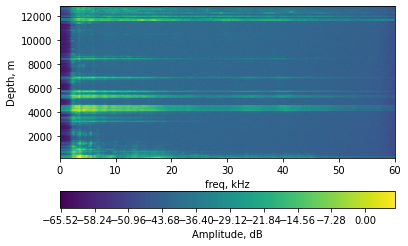

In [190]:
plt.contourf(Xs, Ys, Zs, 1000)
plt.xlabel('freq, kHz')
plt.ylabel('Depth, m')
plt.colorbar(label = 'Amplitude, dB', location = 'bottom')
plt.show()

In [193]:
DEPTH = []
for i in D1:
    DEPTH.append(i[0])

In [222]:
save2las(r"C:\Users\rafil\TGT_Jupyter\ex_1.las", DEPTH, 'm' , [np.array(Zs)], ["SMALL GRAINS PANEL"], ["frac"], fmt="%.6e")

file C:\Users\rafil\TGT_Jupyter\ex_1.las saved successfully.


In [331]:
from scipy.io.wavfile import write

write(r"C:\Users\rafil\TGT_Jupyter\audio3.wav", rate = 120000, data = np.int16(np.concatenate([DATA1[0][i] for i in range(320)]*100))*1000)

In [234]:
DATA

C:\Users\rafil\AppData\Local\Temp/ipykernel_5680/986317594.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(DATA1)


array([array([[ 22,  37,  19, ...,   7,  -6, -28],
              [ -8,  39,   6, ...,   7,  20, -26],
              [ 44,  45,  24, ...,  32,  29, -26],
              ...,
              [ 45,  35, -26, ...,  21,  20,  25],
              [ 19,  10, -15, ..., -44, -25, -31],
              [ 10,  12, -21, ...,  -9,  -2, -52]]),
       array([[ 64,  49,  34, ...,  33,  30,  59],
              [ 27,   6,  21, ..., -19,   8, -17],
              [ 24,  30,  58, ...,  23,  27,  27],
              ...,
              [ -9, -38, -12, ...,  22,  39,  12],
              [ 24,   9,  -2, ...,   0, -52, -40],
              [  1,   0,  -3, ...,  29,  19,  20]]),
       array([[-58, -73, -58, ...,  44,  48,  15],
              [ 74, 116,  66, ...,  34,   4,  24],
              [ 39, -19, -34, ...,  14,  49,  46],
              ...,
              [ 20,   3,  21, ...,  48,  20, -20],
              [ 84, 113, 101, ...,  44,  45,  58],
              [  7, -27,  17, ...,  77,  24,  27]]),
       array([[-40,

In [260]:
prim1 = [1,2,3,4,5]
prim2= [1,2,3,4,5]
prim1+prim2

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [268]:
np.int16(1000*(np.array([DATA1[0][i] for i in range(10)])))
write(r"C:\Users\rafil\TGT_Jupyter\audio1.wav", rate = 1024//10, data = primer)

In [275]:
DATA1[0][0]+DATA1[0][1]

array([ 14,  76,  25, ...,  14,  14, -54])

In [278]:
len(DATA1[0][0]+DATA1[0][1])

1024

In [286]:
a = np.array(1, 2, 3)
b = np.array(1, 2, 3)
c = np.array(1, 2, 3)
d = np.array(1, 2, 3)
np.concatenate((a, b, c, d), axis=1)

TypeError: array() takes from 1 to 2 positional arguments but 3 were given

In [280]:
type(DATA1[0][0])

numpy.ndarray

In [291]:
a = np.array([1, 2, 3])
b = np.array([5, 6])
len(np.concatenate([DATA1[0][0] for i in range(10)]))


10240

In [301]:
np.concatenate([[DATA1[j][0] for i in range(320)] for j in range(100)])

array([[ 22,  37,  19, ...,   7,  -6, -28],
       [ 22,  37,  19, ...,   7,  -6, -28],
       [ 22,  37,  19, ...,   7,  -6, -28],
       ...,
       [ 32,   7,  33, ...,  12,  29,  -2],
       [ 32,   7,  33, ...,  12,  29,  -2],
       [ 32,   7,  33, ...,  12,  29,  -2]])

In [321]:
list(DATA1[0][0])

[22,
 37,
 19,
 13,
 -6,
 -4,
 -7,
 -50,
 -11,
 -14,
 -39,
 -18,
 0,
 -22,
 2,
 -36,
 -19,
 40,
 -8,
 2,
 22,
 46,
 61,
 42,
 28,
 73,
 77,
 61,
 10,
 38,
 46,
 12,
 34,
 22,
 -40,
 47,
 -5,
 59,
 15,
 -16,
 23,
 12,
 5,
 23,
 47,
 12,
 17,
 14,
 -8,
 -16,
 1,
 -58,
 -29,
 -9,
 -37,
 -53,
 -22,
 -31,
 -9,
 -15,
 -40,
 27,
 62,
 36,
 53,
 53,
 0,
 0,
 74,
 79,
 53,
 70,
 66,
 50,
 42,
 30,
 61,
 60,
 18,
 10,
 39,
 5,
 -17,
 -61,
 -47,
 25,
 -41,
 -49,
 -30,
 -6,
 3,
 4,
 5,
 7,
 -12,
 -29,
 -26,
 10,
 47,
 13,
 14,
 50,
 -10,
 17,
 9,
 28,
 57,
 17,
 44,
 65,
 56,
 14,
 40,
 75,
 78,
 65,
 59,
 17,
 -9,
 -39,
 -25,
 19,
 -30,
 -36,
 -15,
 -43,
 -28,
 -11,
 -54,
 -25,
 3,
 20,
 34,
 15,
 4,
 8,
 7,
 42,
 17,
 52,
 49,
 -25,
 -8,
 45,
 -9,
 0,
 42,
 13,
 50,
 53,
 -18,
 44,
 68,
 37,
 59,
 82,
 37,
 65,
 29,
 -8,
 40,
 10,
 -5,
 29,
 2,
 -40,
 -107,
 -43,
 -30,
 -85,
 -54,
 -17,
 -70,
 -44,
 -9,
 -21,
 24,
 57,
 55,
 82,
 40,
 17,
 59,
 56,
 69,
 100,
 65,
 87,
 74,
 26,
 23,
 20,
 8,
 -